In [3]:
#Spinal Fractures YOLOv11n, 50 epochs, 256x256 images
#Jory Hamilton
#12/5/25
#Gemini-assisted code

In [4]:
#Install Kaggle API, pyyaml, ultralytics enviroment
!pip install -q kaggle
!pip install pyyaml
!pip install ultralytics --upgrade #Enviroment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.8 MB/s eta 0:00:00


In [18]:
#Import libraries
import os
from google.colab import files
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from ultralytics import YOLO
import yaml
import pandas as pd

In [6]:
#Check if the API key already exists
if not os.path.exists('/root/.kaggle/kaggle.json'):
    print('Please upload your personal kaggle.json file:')

    #Prompt for upload
    uploaded = files.upload()

    #Move the file to the correct directory
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print('\nKaggle API key configured successfully.')
else:
    print('Kaggle API key is already configured.')

Please upload your personal kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle API key configured successfully.


In [7]:
#Replace with your dataset id here
KAGGLE_DATASET_ID = 'andymalinsky/rsna-2022-hdf5-subset'

print('Downloading dataset...')
!kaggle datasets download -d {KAGGLE_DATASET_ID}

Dataset URL: https://www.kaggle.com/datasets/andymalinsky/rsna-2022-hdf5-subset
License(s): CC0-1.0
 96% 3.38G/3.51G [00:08<00:00, 286MB/s]
100% 3.51G/3.51G [00:08<00:00, 436MB/s]


In [8]:
# Unzip and move to the local Colab storage for training
zip_name = KAGGLE_DATASET_ID.split('/')[-1] + '.zip'
!unzip -q '{zip_name}'

# This is the path the training script will use
HDF5_FILE_PATH = '/content/fracture_dataset_subset.h5'

Data Prep for YOLOv11n

In [9]:
#Load HDF5 Dataset
print(f"Opening HDF5 file: {HDF5_FILE_PATH}")
with h5py.File(HDF5_FILE_PATH, 'r') as hf:
    print("HDF5 file opened successfully.")
    print("Keys in the HDF5 file:")
    for key in hf.keys():
        print(f"- {key}")

Opening HDF5 file: /content/fracture_dataset_subset.h5
HDF5 file opened successfully.
Keys in the HDF5 file:
- SliceNumber
- StudyInstanceUID
- bboxes
- images
- labels
- split


In [10]:
#Prepare Directory Structure

YOLO_DATA_DIR = 'yolo_dataset'

#Create the main output directory
os.makedirs(YOLO_DATA_DIR, exist_ok=True)
print(f"Main YOLO dataset directory created: {YOLO_DATA_DIR}")

#Define dataset splits
splits = ['train', 'val', 'test']

#Create subdirectories for each split (images and labels)
for split in splits:
    images_dir = os.path.join(YOLO_DATA_DIR, split, 'images')
    labels_dir = os.path.join(YOLO_DATA_DIR, split, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    print(f"Created directories for {split}: {images_dir} and {labels_dir}")

print("YOLO dataset directory structure prepared successfully.")

Main YOLO dataset directory created: yolo_dataset
Created directories for train: yolo_dataset/train/images and yolo_dataset/train/labels
Created directories for val: yolo_dataset/val/images and yolo_dataset/val/labels
Created directories for test: yolo_dataset/test/images and yolo_dataset/test/labels
YOLO dataset directory structure prepared successfully.


In [11]:
#Process and Convert Annotations
hf = h5py.File(HDF5_FILE_PATH, 'r')
images_dataset = hf['images']
bboxes_dataset = hf['bboxes']
labels_dataset = hf['labels']
split_dataset = hf['split']
print("HDF5 datasets loaded successfully.")

HDF5 datasets loaded successfully.


In [12]:
def convert_to_yolo_coords(image_width, image_height, bbox):
    #bbox: [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = bbox

    #Clamp coordinates to image boundaries and ensure they are floats for calculations
    x_min_clamped = max(0.0, float(x_min))
    y_min_clamped = max(0.0, float(y_min))
    x_max_clamped = min(float(image_width), float(x_max))
    y_max_clamped = min(float(image_height), float(y_max))

    #Recalculate width and height after clamping
    box_width = x_max_clamped - x_min_clamped
    box_height = y_max_clamped - y_min_clamped

    #If the box is invalid (zero or negative area after clamping), return zeros
    if box_width <= 0 or box_height <= 0:
        return [0.0, 0.0, 0.0, 0.0] # Return a zero-area bbox, YOLO will likely ignore it

    #Calculate center coordinates
    x_center = (x_min_clamped + x_max_clamped) / 2
    y_center = (y_min_clamped + y_max_clamped) / 2

    #Normalize coordinates
    x_center_norm = x_center / image_width
    y_center_norm = y_center / image_height
    width_norm = box_width / image_width
    height_norm = box_height / image_height

    #Ensure normalized coordinates are within [0, 1] range (should be due to clamping)
    x_center_norm = max(0.0, min(1.0, x_center_norm))
    y_center_norm = max(0.0, min(1.0, y_center_norm))
    width_norm = max(0.0, min(1.0, width_norm))
    height_norm = max(0.0, min(1.0, height_norm))

    return [x_center_norm, y_center_norm, width_norm, height_norm]

#Initialize a list to store processed data
#Each item will be a dictionary containing 'image', 'split', and 'yolo_annotations'
processed_data = []

print("convert_to_yolo_coords function defined and processed_data list initialized.")

convert_to_yolo_coords function defined and processed_data list initialized.


In [13]:
#Re-open the HDF5 file and assign datasets inside this cell for robustness
with h5py.File(HDF5_FILE_PATH, 'r') as hf:
    images_dataset = hf['images']
    bboxes_dataset = hf['bboxes']
    labels_dataset = hf['labels']
    split_dataset = hf['split']

    #Clear processed_data list to prevent duplicate entries if re-running
    processed_data = []

    for i in range(len(images_dataset)):
        image_data = images_dataset[i]
        image_height, image_width = image_data.shape[:2]

        # HDF5 stores lists of lists, so we need to iterate if there are multiple bounding boxes
        raw_bboxes_for_image = bboxes_dataset[i]
        labels_for_image = labels_dataset[i]

        #Map the numerical split ID to its string representation
        #Assuming splits_dataset contains integers 0, 1, 2 corresponding to 'train', 'val', 'test'
        #The 'splits' variable is available from previous steps: splits = ['train', 'val', 'test']
        split_index = int(split_dataset[i]) # Ensure it's an integer for indexing
        split_for_image = splits[split_index]

        yolo_annotations = []
        #Check if there are bounding boxes for the current image
        if raw_bboxes_for_image.size > 0 and not np.all(raw_bboxes_for_image == -1): # Also check if not all are -1 placeholders
            for j in range(len(raw_bboxes_for_image)):
                bbox = raw_bboxes_for_image[j]
                if np.all(bbox == -1): # Skip placeholder bounding boxes
                    continue

                #Use labels_for_image directly as it appears to be a scalar class ID for the image
                class_id = int(labels_for_image)

                yolo_coords = convert_to_yolo_coords(image_width, image_height, bbox)
                #YOLO format: class_id x_center y_center width height
                yolo_annotations.append(f"{int(class_id)} {yolo_coords[0]:.6f} {yolo_coords[1]:.6f} {yolo_coords[2]:.6f} {yolo_coords[3]:.6f}")

        processed_data.append({
            'image_index': i,
            'image_data': image_data,
            'split': split_for_image,
            'yolo_annotations': yolo_annotations
        })

print(f"Processed {len(processed_data)} images and their annotations.")
print("HDF5 file operations completed.")


Processed 28812 images and their annotations.
HDF5 file operations completed.


## Save Images and YOLO Labels

In [14]:
for item in processed_data:
    image_index = item['image_index']
    image_data = item['image_data']
    split = item['split']
    yolo_annotations = item['yolo_annotations']

    #Format image_index with leading zeros (e.g., 000001)
    #Assuming a maximum of 6 digits for image index based on typical dataset sizes
    formatted_image_index = str(image_index).zfill(6)

    #Construct image file path
    image_filename = f"{formatted_image_index}.jpeg"
    image_path = os.path.join(YOLO_DATA_DIR, split, 'images', image_filename)

    #Prepare image data for saving
    #plt.imsave expects float data to be in [0, 1] range for imshow,
    #or it will normalize if the dtype is float and min/max are outside [0,1].
    #Assuming image_data is already normalized or within a reasonable range for direct saving.
    #If it's a single-channel (grayscale) image, convert to 3-channel for consistent JPEG output
    if image_data.ndim == 2 or (image_data.ndim == 3 and image_data.shape[-1] == 1):
        # Stack the single channel to make it 3-channel for JPEG compatibility and consistent visualization
        image_to_save = np.stack([image_data.squeeze()] * 3, axis=-1)
    else:
        image_to_save = image_data

    #Save image as JPEG
    plt.imsave(image_path, image_to_save, cmap='gray') # Use cmap='gray' for potentially grayscale output

    #Construct label file path
    label_filename = f"{formatted_image_index}.txt"
    label_path = os.path.join(YOLO_DATA_DIR, split, 'labels', label_filename)

    #Write YOLO annotations to the label file
    with open(label_path, 'w') as f:
        if yolo_annotations:
            for annotation in yolo_annotations:
                f.write(annotation + '\n')

print("Images and YOLO labels saved successfully to their respective directories.")

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/h5py/_hl/dataset.py", line 539, in shape
    shape = self.id.shape
            ^^^^^^^^^^^^^
  File "h5py/h5d.pyx", line 205, in h5py.h5d.DatasetID.shape.__get__
  File "h5py/h5d.pyx", line 206, in h5py.h5d.DatasetID.shape.__get__
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5d.pyx", line 372, in h5py.h5d.DatasetID.get_space
RuntimeError: Unable to synchronously get dataspace (identifier is not of specified type)
ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_de

Images and YOLO labels saved successfully to their respective directories.


In [15]:
#Define the full path where the data.yaml file will be created
yaml_file_path = os.path.join(YOLO_DATA_DIR, 'data.yaml')

#Determine the number of classes (nc) and a list of corresponding class names (names)
nc = 2 # Assuming 0 for 'no fracture' and 1 for 'fracture' based on common dataset labeling for binary classification with YOLO.
names = ['no_fracture', 'fracture'] # Adjust based on actual class IDs present in HDF5 labels_dataset if needed

#Construct a Python dictionary containing the YOLO dataset configuration
data_yaml_content = {
    'path': os.path.abspath(YOLO_DATA_DIR), # Absolute path to the dataset root
    'train': 'train/images',
    'val': 'val/images',
    'test': 'test/images',
    'nc': nc,
    'names': names
}

#Use yaml.dump() to write the created dictionary to the data.yaml file
with open(yaml_file_path, 'w') as f:
    yaml.dump(data_yaml_content, f)

#Print a confirmation message
print(f"data.yaml has been successfully generated at: {yaml_file_path}")

#For verification, print the entire content of the newly created data.yaml file
print("\nContent of data.yaml:")
with open(yaml_file_path, 'r') as f:
    print(f.read())

data.yaml has been successfully generated at: yolo_dataset/data.yaml

Content of data.yaml:
names:
- no_fracture
- fracture
nc: 2
path: /content/yolo_dataset
test: test/images
train: train/images
val: val/images



In [17]:
#Load the model
#yolo11n.pt is the 'nano' version (fastest).
model = YOLO("yolo11n.pt")

#Train the model
results = model.train(
    data=yaml_file_path,  # Path to your config file, corrected to use the variable
    epochs=50,                                   # 50-100 is usually a good start
    imgsz=256,                                   # X-ray resolution
    batch=16,                                     # Adjust based on GPU VRAM
    name="fracture_v11_run4",                     # Name of the run (re-using previous name for consistency)
    augment=True,                                 # Data augmentation (vital for small datasets)
    optimizer='auto',                             # Automatically selects AdamW or SGD
   #patience=30                                  # Early stopping patience
)

#Validation
#Evaluate performance on the validation set
metrics = model.val()
print(f"mAP@50: {metrics.box.map50}")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=fracture_v11_run4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, 

Using sample image for inference: yolo_dataset/test/images/006280.jpeg

image 1/1 /content/yolo_dataset/test/images/006280.jpeg: 256x256 (no detections), 10.7ms
Speed: 0.5ms preprocess, 10.7ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 256)


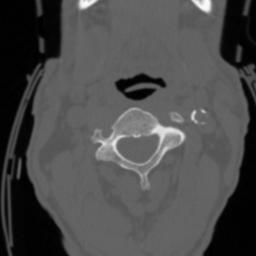

In [19]:


#Load custom/trained model
#Path points to the 'best.pt' file generated during your training run
model = YOLO("/content/runs/detect/fracture_v11_run4/weights/best.pt") #Adjusted path based on previous run name

#Get a sample image from the test set for inference
test_image_dir = os.path.join(YOLO_DATA_DIR, 'test', 'images')
#List all files in the test image directory
image_files = os.listdir(test_image_dir)

#Filter for image files (e.g., .jpeg, .jpg, .png)
image_files = [f for f in image_files if f.lower().endswith(('.jpeg', '.jpg', '.png'))]

if image_files:
    #Pick the first image found in the test directory
    sample_image_path = os.path.join(test_image_dir, image_files[0])
    print(f"Using sample image for inference: {sample_image_path}")

    #Predict on the sample image
    results = model(sample_image_path)

    #Show results
    results[0].show()
else:
    print(f"No image files found in {test_image_dir} to perform inference on.")


Loading training results from: /content/runs/detect/fracture_v11_run4/results.csv


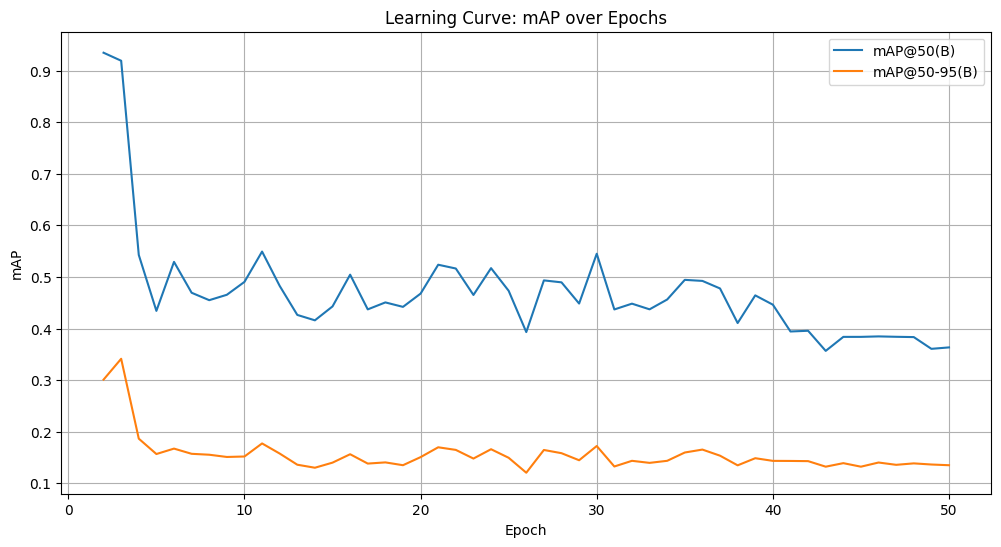

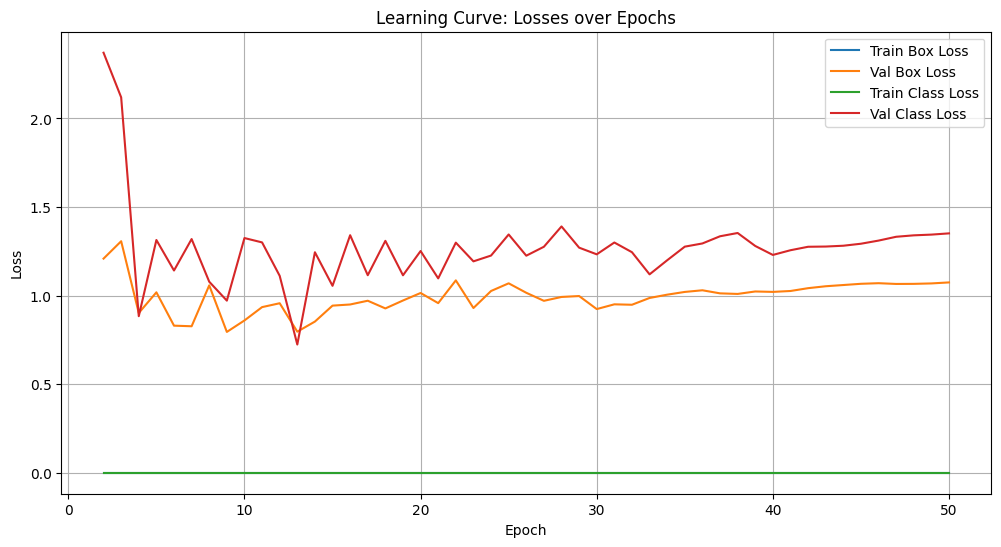

In [29]:
#Define the path to the training results CSV file
results_path = '/content/runs/detect/fracture_v11_run4/results.csv'

#Check if the file exists
if os.path.exists(results_path):
    print(f"Loading training results from: {results_path}")
    # Load the results CSV, skipping the first row which contains headers with special characters
    # and might cause parsing issues. We'll manually set column names.
    results_df = pd.read_csv(results_path, skiprows=1)

    #Assign meaningful column names based on Ultralytics output structure
    #Common columns are 'epoch', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'train/box_loss', 'val/box_loss', etc.
    #Adjust these column names if your results.csv has a different structure after skipping the first row.
    results_df.columns = [
        'epoch',
        'metrics/precision(B)',
        'metrics/recall(B)',
        'metrics/mAP50(B)',
        'metrics/mAP50-95(B)',
        'train/box_loss',
        'train/cls_loss',
        'train/dfl_loss',
        'train/obj_loss', # Added missing column
        'val/box_loss',
        'val/cls_loss',
        'val/dfl_loss',
        'val/obj_loss',   # Added missing column
        'labels',
        'lr'
    ]

    #Plotting mAP@50 over epochs
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@50(B)')
    plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@50-95(B)')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.title('Learning Curve: mAP over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

    #Plotting Loss Curves
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
    plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Val Box Loss')
    plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss')
    plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Val Class Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve: Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print(f"Error: Training results file not found at {results_path}")
    print("Please ensure the training run completed and generated a 'results.csv' file.")

Loading confusion matrix from: /content/runs/detect/fracture_v11_run4/confusion_matrix.png


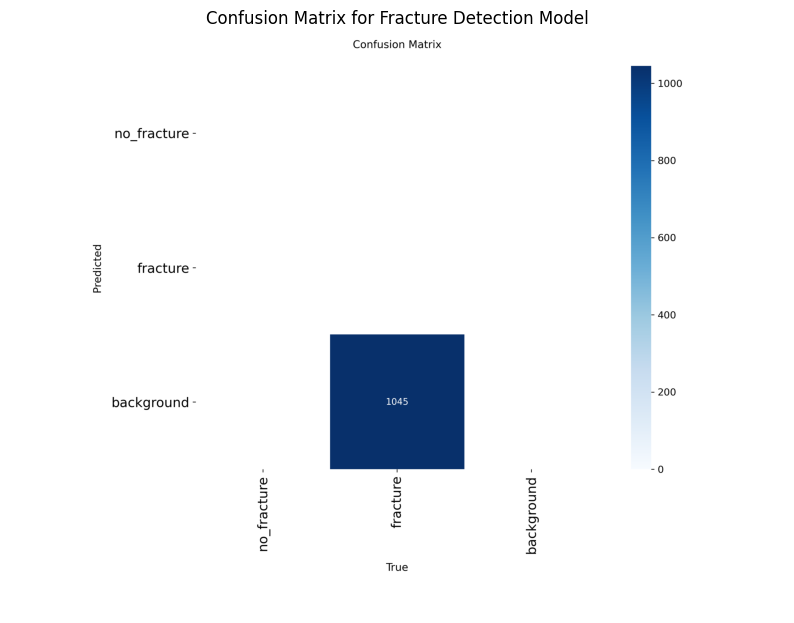

In [22]:
#Construct the full path to the confusion matrix image
confusion_matrix_path = os.path.join('/content/runs/detect/fracture_v11_run4', 'confusion_matrix.png')

#Check if the file exists before attempting to load
if os.path.exists(confusion_matrix_path):
    print(f"Loading confusion matrix from: {confusion_matrix_path}")
    #Use matplotlib.pyplot.imread() to load the image
    confusion_matrix_img = plt.imread(confusion_matrix_path)

    #Display the image using matplotlib.pyplot.imshow()
    plt.figure(figsize=(10, 10))
    plt.imshow(confusion_matrix_img)

    #Add a title to the plot
    plt.title("Confusion Matrix for Fracture Detection Model")

    #Use matplotlib.pyplot.axis('off') to hide the axes
    plt.axis('off')

    #Show the plot
    plt.show()
else:
    print(f"Error: Confusion matrix not found at {confusion_matrix_path}")

Additonal diagnostics and analysis if needed

In [23]:
#Identify sample images with fractures
#Part of the process to verifying YOLO annotations

#Ensure HDF5_FILE_PATH and splits are defined from previous cells
#HDF5_FILE_PATH = '/content/fracture_dataset_subset.h5'
#splits = ['train', 'val', 'test']

#Open the HDF5 file in read mode
with h5py.File(HDF5_FILE_PATH, 'r') as hf:
    print(f"Opened HDF5 file: {HDF5_FILE_PATH}")

    #Access the labels_dataset and split_dataset
    labels_dataset = hf['labels']
    split_dataset = hf['split']

    #Initialize an empty list to store fracture image samples
    fracture_image_samples = []
    print("Starting to search for fracture images...")

    #Iterate through the labels_dataset
    for i in range(len(labels_dataset)):
        # Check if the class_id for the current image is 1 (fracture)
        class_id = int(labels_dataset[i])

        #If the class_id is 1, process the image
        if class_id == 1:
            # a. Determine its dataset split
            split_index = int(split_dataset[i])
            split_for_image = splits[split_index]

            #Add a dictionary containing the image_index and its split to the list
            fracture_image_samples.append({
                'image_index': i,
                'split': split_for_image
            })

        #Continue until at least 5 images with fractures have been identified
        if len(fracture_image_samples) >= 5:
            break

    #Print the fracture_image_samples list
    print("Identified fracture image samples:")
    for sample in fracture_image_samples:
        print(sample)


Opened HDF5 file: /content/fracture_dataset_subset.h5
Starting to search for fracture images...
Identified fracture image samples:
{'image_index': 7, 'split': 'train'}
{'image_index': 15, 'split': 'train'}
{'image_index': 19, 'split': 'train'}
{'image_index': 22, 'split': 'test'}
{'image_index': 25, 'split': 'train'}


Visualizing YOLO annotations for 5 fracture images...


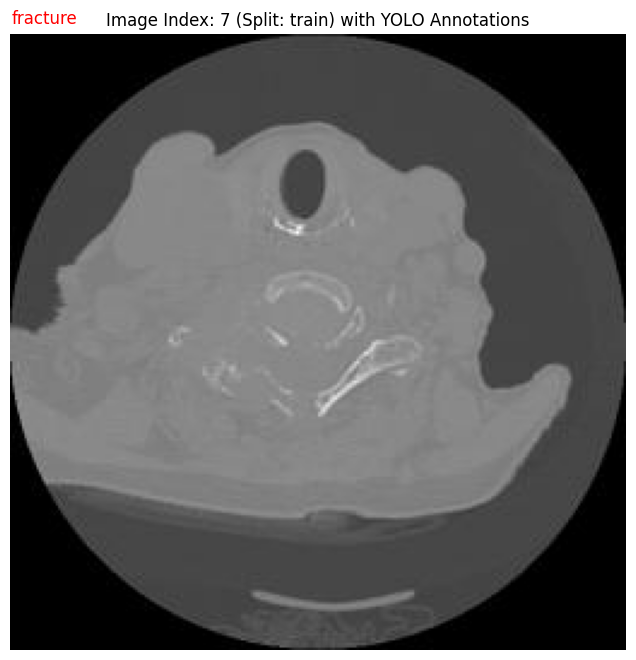

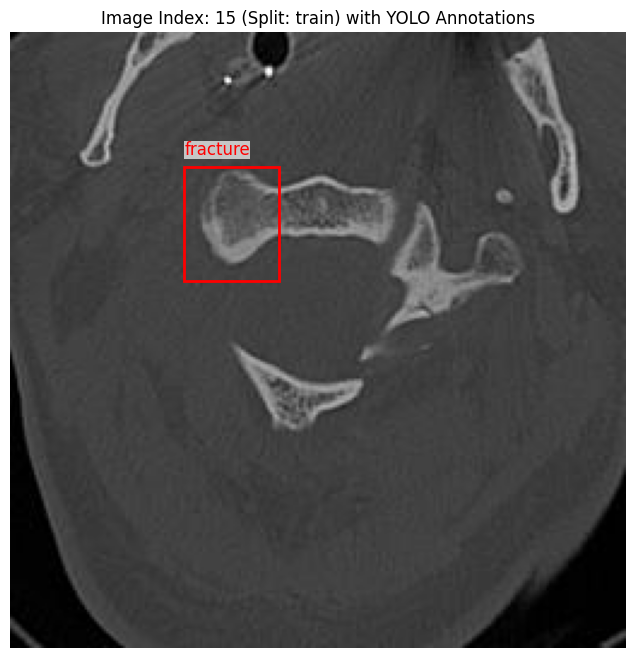

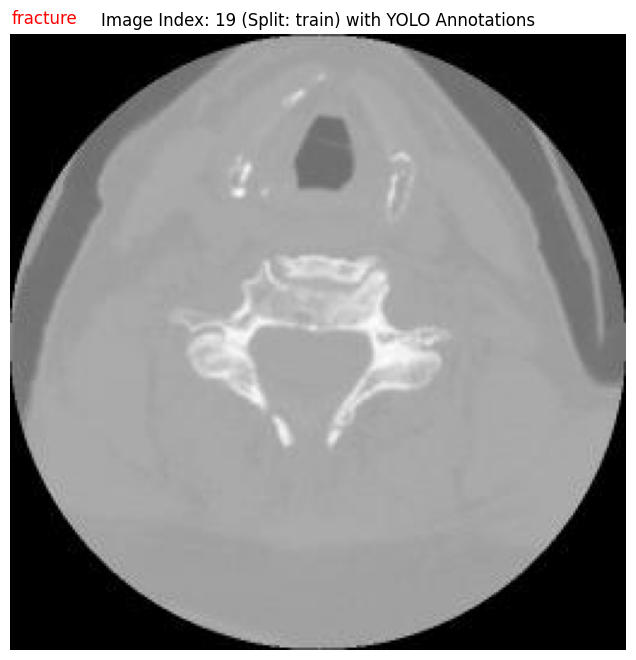

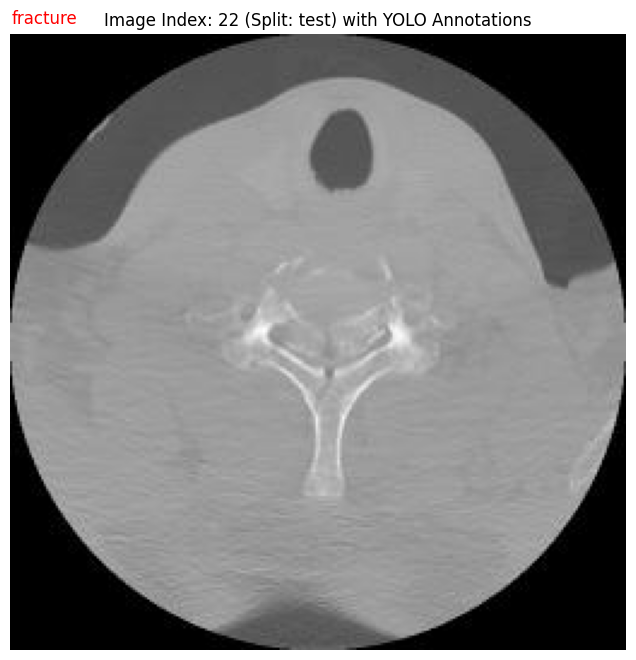

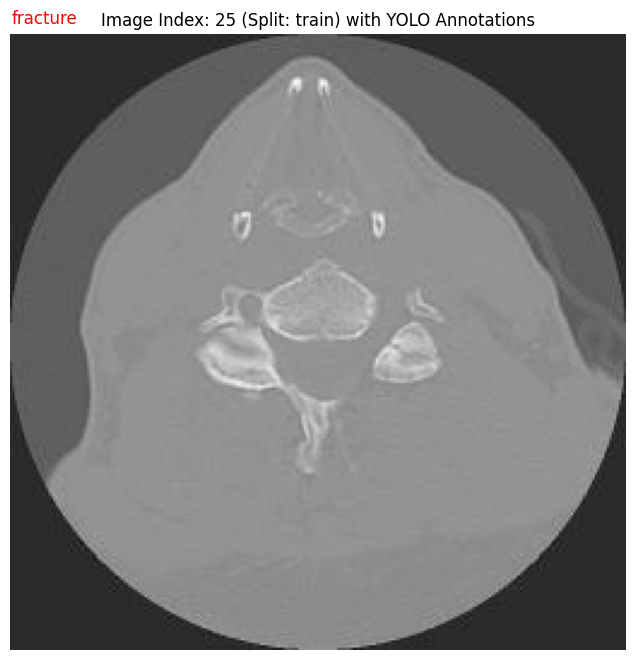

Finished visualizing YOLO annotations.


In [24]:
#Ensure YOLO_DATA_DIR and names (class labels) are accessible
#YOLO_DATA_DIR = 'yolo_dataset'
#names = ['no_fracture', 'fracture']

print(f"Visualizing YOLO annotations for {len(fracture_image_samples)} fracture images...")

for i, sample in enumerate(fracture_image_samples):
    image_index = sample['image_index']
    split = sample['split']

    #Format image_index with leading zeros (e.g., 000001)
    formatted_image_index = str(image_index).zfill(6)

    #Construct image and label file paths
    image_filename = f"{formatted_image_index}.jpeg"
    label_filename = f"{formatted_image_index}.txt"

    image_path = os.path.join(YOLO_DATA_DIR, split, 'images', image_filename)
    label_path = os.path.join(YOLO_DATA_DIR, split, 'labels', label_filename)

    if not os.path.exists(image_path):
        print(f"Image not found at {image_path}. Skipping.")
        continue
    if not os.path.exists(label_path):
        print(f"Label file not found at {label_path}. Skipping.")
        continue

    #Load the JPEG image
    image = plt.imread(image_path)
    image_height, image_width = image.shape[:2]

    #Create plot for the image
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)

    #Read YOLO annotations from the .txt file
    with open(label_path, 'r') as f:
        annotations = f.readlines()

    #Parse and draw bounding boxes
    if annotations:
        for annotation_line in annotations:
            parts = annotation_line.strip().split()
            if len(parts) == 5:
                class_id_yolo, x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts)
                class_id_yolo = int(class_id_yolo)

                # Convert normalized YOLO coordinates to pixel coordinates
                center_x_px = x_center_norm * image_width
                center_y_px = y_center_norm * image_height
                width_px = width_norm * image_width
                height_px = height_norm * image_height

                x_min_px = center_x_px - (width_px / 2)
                y_min_px = center_y_px - (height_px / 2)

                # Create a rectangle patch
                rect = patches.Rectangle(
                    (x_min_px, y_min_px),
                    width_px,
                    height_px,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )

                # Add the rectangle to the plot
                ax.add_patch(rect)

                # Add class label
                if class_id_yolo < len(names):
                    class_name = names[class_id_yolo]
                    ax.text(
                        x_min_px,
                        y_min_px - 5, # Position above the box
                        f'{class_name}',
                        color='r',
                        fontsize=12,
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0)
                    )
            else:
                print(f"Warning: Malformed annotation line in {label_filename}: {annotation_line.strip()}")
    else:
        print(f"No annotations found in {label_filename} for image index {image_index}.")

    # Add a title to the plot
    ax.set_title(f"Image Index: {image_index} (Split: {split}) with YOLO Annotations")

    # Hide axes
    ax.axis('off')

    # Display the plot
    plt.show()

print("Finished visualizing YOLO annotations.")

In [25]:
#Initialize an empty dictionary to store fracture counts for each split
fracture_counts = {'train': 0, 'val': 0, 'test': 0}

print("Counting fracture instances in YOLO dataset...")

#Ensure YOLO_DATA_DIR and splits are accessible from previous cells
#YOLO_DATA_DIR = 'yolo_dataset'
#splits = ['train', 'val', 'test']

#Loop through each split
for split in splits:
    #Construct the full path to its 'labels' directory
    labels_dir = os.path.join(YOLO_DATA_DIR, split, 'labels')

    #Check if the labels directory exists
    if not os.path.exists(labels_dir):
        print(f"Warning: Labels directory not found for split '{split}' at {labels_dir}")
        continue

    #Iterate through each .txt file in the current split's labels directory
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            label_filepath = os.path.join(labels_dir, filename)

            #Flag to check if fracture is found in the current image
            found_fracture = False

            #Open and read the label file
            with open(label_filepath, 'r') as f:
                for line in f:
                    # 6. Check if any line in the file begins with '1' (class_id 1 for 'fracture')
                    if line.strip().startswith('1 '):
                        found_fracture = True
                        break # Found a fracture, no need to check further lines in this file

            #If a line starting with '1' is found, increment the count
            if found_fracture:
                fracture_counts[split] += 1

#Print the fracture_counts dictionary
print("\nSummary of images with fracture annotations per split:")
for split, count in fracture_counts.items():
    print(f"  {split.capitalize()}: {count} images with fracture annotations")


Counting fracture instances in YOLO dataset...

Summary of images with fracture annotations per split:
  Train: 5186 images with fracture annotations
  Val: 1045 images with fracture annotations
  Test: 972 images with fracture annotations


In [26]:
#Initialize a dictionary to store fracture bounding box counts per image for each split
fracture_bbox_counts_per_image = {
    'train': [],
    'val': [],
    'test': []
}

print("Counting fracture bounding boxes per image for each split...")

#Ensure YOLO_DATA_DIR and splits are accessible from previous cells
#YOLO_DATA_DIR = 'yolo_dataset'
#splits = ['train', 'val', 'test']

#Loop through each split
for split in splits:
    #Construct the full path to its 'labels' directory
    labels_dir = os.path.join(YOLO_DATA_DIR, split, 'labels')

    #Check if the labels directory exists
    if not os.path.exists(labels_dir):
        print(f"Warning: Labels directory not found for split '{split}' at {labels_dir}")
        continue

    #Iterate through each .txt file in the current split's labels directory
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            label_filepath = os.path.join(labels_dir, filename)

            #Initialize a counter for bounding boxes in the current image
            current_image_bbox_count = 0

            #Open and read the label file
            with open(label_filepath, 'r') as f:
                for line in f:
                    #For each line, check if it starts with '1 ' (class_id 1 for 'fracture')
                    if line.strip().startswith('1 '):
                        #If it does, increment current_image_bbox_count
                        current_image_bbox_count += 1

            #After processing all lines in the file, if current_image_bbox_count is > 0,
            #    append this count to the corresponding list in the dictionary for the current split.
            if current_image_bbox_count > 0:
                fracture_bbox_counts_per_image[split].append(current_image_bbox_count)

#After processing all files for all splits, print the dictionary
print("\nSummary of fracture bounding box counts per image:")
for split, counts in fracture_bbox_counts_per_image.items():
    print(f"  {split.capitalize()} split: {len(counts)} images with fractures, total bounding boxes: {sum(counts)}")
    #Optional: print the list of counts for more detail
print(f"    Counts: {counts}")

Counting fracture bounding boxes per image for each split...

Summary of fracture bounding box counts per image:
  Train split: 5186 images with fractures, total bounding boxes: 5186
  Val split: 1045 images with fractures, total bounding boxes: 1045
  Test split: 972 images with fractures, total bounding boxes: 972
    Counts: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [27]:
#Calculate descriptive statistics for fracture bounding box counts per image for each split
print("Calculating descriptive statistics for fracture bounding box counts:")
descriptive_stats = {}
for split, counts in fracture_bbox_counts_per_image.items():
    if counts:
        descriptive_stats[split] = {
            'mean': np.mean(counts),
            'median': np.median(counts),
            'min': np.min(counts),
            'max': np.max(counts)
        }
    else:
        descriptive_stats[split] = {
            'mean': 0,
            'median': 0,
            'min': 0,
            'max': 0
        }

#Print the descriptive statistics
for split, stats in descriptive_stats.items():
    print(f"\nDescriptive Statistics for {split.capitalize()} Split (Fracture BBoxes per Image):")
    for stat, value in stats.items():
        print(f"  {stat.capitalize()}: {value:.2f}")


Calculating descriptive statistics for fracture bounding box counts:

Descriptive Statistics for Train Split (Fracture BBoxes per Image):
  Mean: 1.00
  Median: 1.00
  Min: 1.00
  Max: 1.00

Descriptive Statistics for Val Split (Fracture BBoxes per Image):
  Mean: 1.00
  Median: 1.00
  Min: 1.00
  Max: 1.00

Descriptive Statistics for Test Split (Fracture BBoxes per Image):
  Mean: 1.00
  Median: 1.00
  Min: 1.00
  Max: 1.00


Generating histograms for fracture bounding box counts...


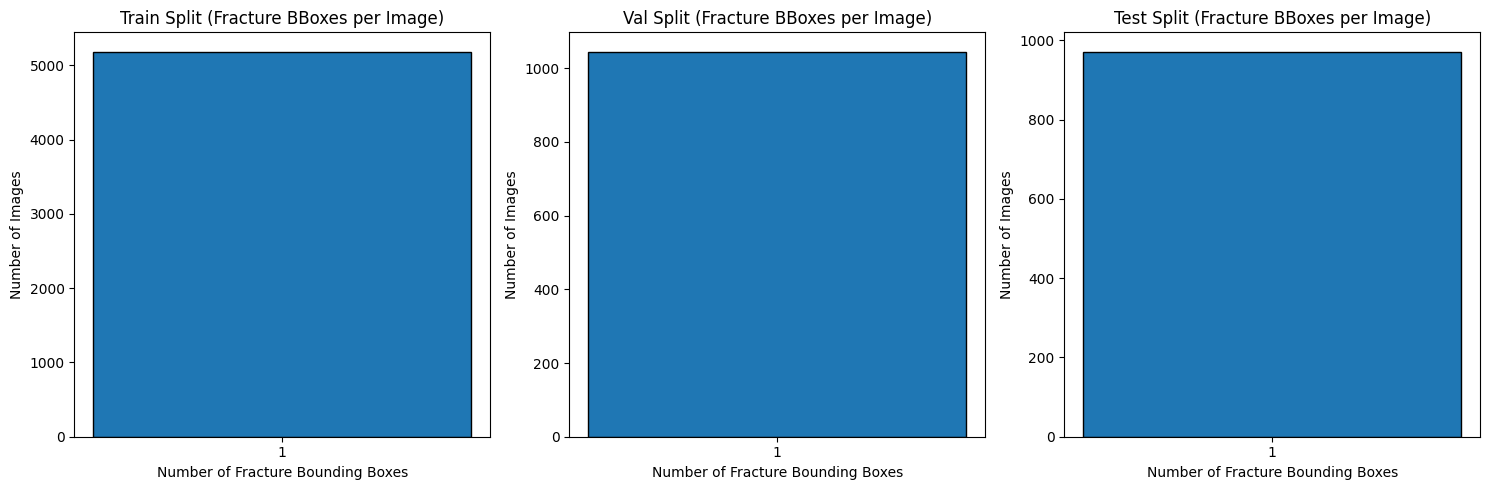

Histograms generated successfully.


In [28]:
#Visualize the distribution of fracture bounding box counts per image for all splits using histograms
print("Generating histograms for fracture bounding box counts...")

plt.figure(figsize=(15, 5))

for i, split in enumerate(splits):
    counts = fracture_bbox_counts_per_image[split]
    if counts:
        plt.subplot(1, len(splits), i + 1)
        plt.hist(counts, bins=range(1, max(counts) + 2), edgecolor='black', align='left')
        plt.title(f'{split.capitalize()} Split (Fracture BBoxes per Image)')
        plt.xlabel('Number of Fracture Bounding Boxes')
        plt.ylabel('Number of Images')
        plt.xticks(range(1, max(counts) + 1))
    else:
        plt.subplot(1, len(splits), i + 1)
        plt.title(f'{split.capitalize()} Split (Fracture BBoxes per Image)')
        plt.text(0.5, 0.5, 'No fracture annotations', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.axis('off')

plt.tight_layout()
plt.show()

print("Histograms generated successfully.")